In [81]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [82]:
dfs = {}
path_to_csvs = '../Resources/finished_city_dfs'
for file in os.listdir(path_to_csvs):
  dfs[file.split('.')[0]] = pd.read_csv(f'{path_to_csvs}/{file}')
df = dfs['Denver_df'].copy()
#enable this if we want per-day week forecast
# df = df[12::24]

date_time = df.pop('Date and Time')
df.index = date_time
numeric_features = [
    'Humidity',
    'Pressure',
    'Temperature',
    'Wind_Speed',
#     'Year Temp Max', 
#     'Year Temp Min', 
    'Year Temp Average',
#     'Month Temp Max', 
#     'Month Temp Min', 
    'Month Temp Average',
#     'Year Pressure Max', 
#     'Year Pressure Min', 
    'Year Pressure Average',
#     'Month Pressure Max', 
#     'Month Pressure Min', 
    'Month Pressure Average',
#     'Year Wind_Speed Max', 
#     'Year Wind_Speed Min', 
    'Year Wind_Speed Average',
#     'Month Wind_Speed Max', 
#     'Month Wind_Speed Min',
    'Month Wind_Speed Average', 
#     'Year Humidity Max', 
#     'Year Humidity Min',
    'Year Humidity Average', 
#     'Month Humidity Max', 
#     'Month Humidity Min',
    'Month Humidity Average'
]

for feature in numeric_features:
  pd.to_numeric(df[feature])
df = df[numeric_features]
normal_df = df.copy()
num_features = len(numeric_features)
column_indices = {name: i for i, name in enumerate(numeric_features)}

train_df = df.iloc[0:31102].copy()[numeric_features]
val_df = df.iloc[31103:35443].copy()[numeric_features]
test_df = df.iloc[35444:].copy()[numeric_features]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

MAX_EPOCHS = 50
#change OUT_STEPS from 24 to 7 for weekly forecast
OUT_STEPS = 24
#change input_width from 24 to 7 for weekly forecast
INPUT_WIDTH = 24

In [83]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.predictions = None

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis = -1)
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model = None, plot_col = 'Temperature', max_subplots = 3):
  inputs, labels = self.example
  plt.figure(figsize = (12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label = 'Inputs', marker = '.', zorder = -10)
    
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index
    
    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors = 'k', label = 'Labels', c = '#2ca02c', s = 64)
    if model is not None:
      predictions = model(inputs)
      self.predictions = predictions
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker = 'X', edgecolors = 'k', label = 'Predictions',
                  c = '#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=100,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

class Baseline(tf.keras.Model):
  def __init__(self, label_index = None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

def compile_and_fit(model, window, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [84]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)
    
def warmup(self,inputs):
  #inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  #predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state 

FeedBack.warmup = warmup

def call(self, inputs, training = None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input
    x = prediction
    # Execute on lstm step
    x, state = self.lstm_cell(x, states = state,
                              training = training)
    # Convert the lstm output to a prediction
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  #predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1,0,2])
  return predictions

FeedBack.call = call

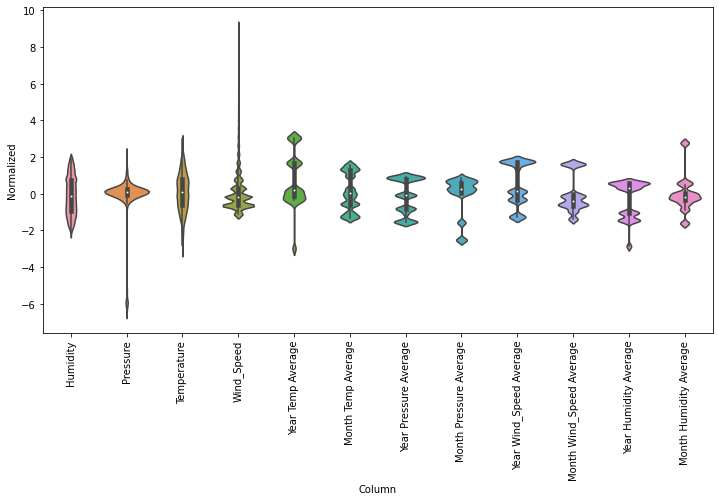

In [85]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [86]:
train_df

,Humidity,Pressure,Temperature,Wind_Speed,Year Temp Average,Month Temp Average,Year Pressure Average,Month Pressure Average,Year Wind_Speed Average,Month Wind_Speed Average,Year Humidity Average,Month Humidity Average
Date and Time,,,,,,,,,,,,
2012-10-01 13:00:00,0.306688,0.351745,0.253277,0.762644,-2.983078,0.020965,-1.068321,-2.519649,1.368215,-0.657935,-2.852559,0.051767
2012-10-01 14:00:00,0.306688,0.351745,0.253027,0.762644,-2.983078,0.020965,-1.068321,-2.519649,1.368215,-0.657935,-2.852559,0.051767
2012-10-01 15:00:00,0.306688,0.351745,0.252340,0.296445,-2.983078,0.020965,-1.068321,-2.519649,1.368215,-0.657935,-2.852559,0.051767
2012-10-01 16:00:00,0.306688,0.351745,0.251653,0.296445,-2.983078,0.020965,-1.068321,-2.519649,1.368215,-0.657935,-2.852559,0.051767
2012-10-01 17:00:00,0.349526,0.351745,0.250966,0.296445,-2.983078,0.020965,-1.068321,-2.519649,1.368215,-0.657935,-2.852559,0.051767
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-07-13 08:00:00,-1.535355,0.022039,0.804538,0.762644,1.679283,1.577573,-1.531299,0.029973,1.790525,-0.625051,-1.448407,-0.548008
2016-07-13 09:00:00,-1.406840,0.052012,0.767353,1.228843,1.679283,1.577573,-1.531299,0.029973,1.790525,-0.625051,-1.448407,-0.548008
2016-07-13 10:00:00,-0.935620,0.052012,0.679040,0.296445,1.679283,1.577573,-1.531299,0.029973,1.790525,-0.625051,-1.448407,-0.548008


Inputs shape (batch, time, features): (100, 24, 12)
Labels shape (batch, time, features): (100, 24, 12)
43/43 [==============================] - 1s 12ms/step - loss: 0.3161 - mean_absolute_error: 0.1904


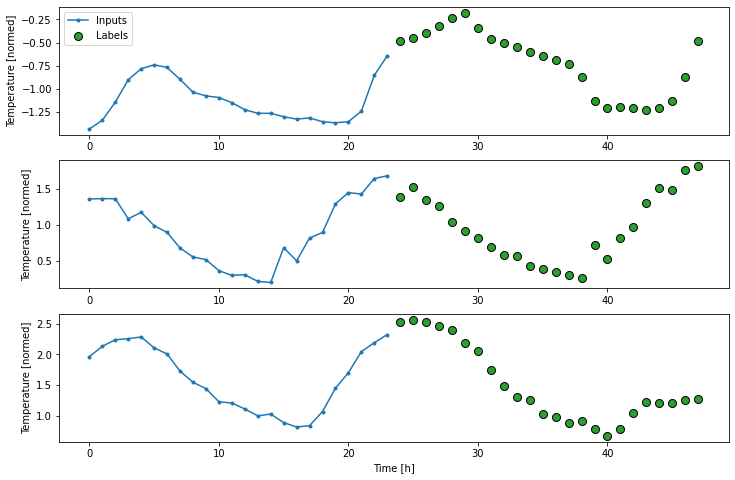

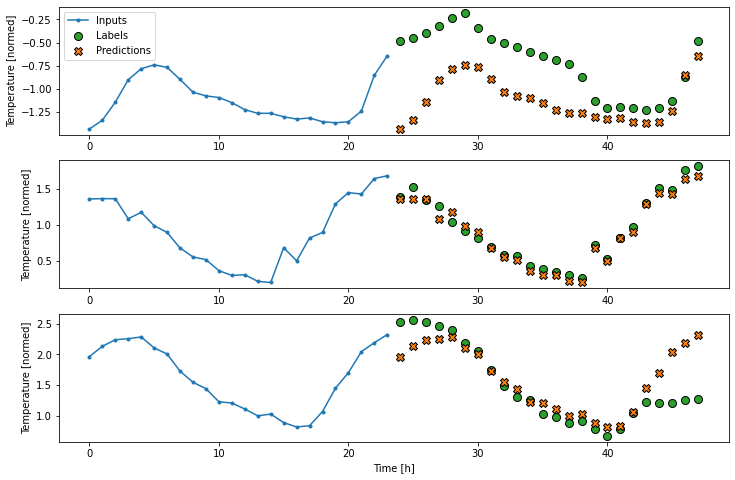

In [87]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=INPUT_WIDTH, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

baseline = Baseline()
baseline.compile(loss = tf.losses.MeanSquaredError(),
                 metrics = [tf.metrics.MeanAbsoluteError()])



last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics = [tf.metrics.MeanAbsoluteError()])

# `WindowGenerator` returns all features as labels if you 
# don't set the `label_columns` argument.
multi_window = WindowGenerator(input_width = INPUT_WIDTH,
                               label_width = OUT_STEPS,
                               shift = OUT_STEPS)

multi_window.plot()
multi_window

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose = 0)



repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss = tf. losses.MeanSquaredError(),
                        metrics = [tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose = 0)
multi_window.plot(repeat_baseline)

**--------RNN--------**

43/43 [==============================] - 1s 25ms/step - loss: 0.8254 - mean_absolute_error: 0.4412


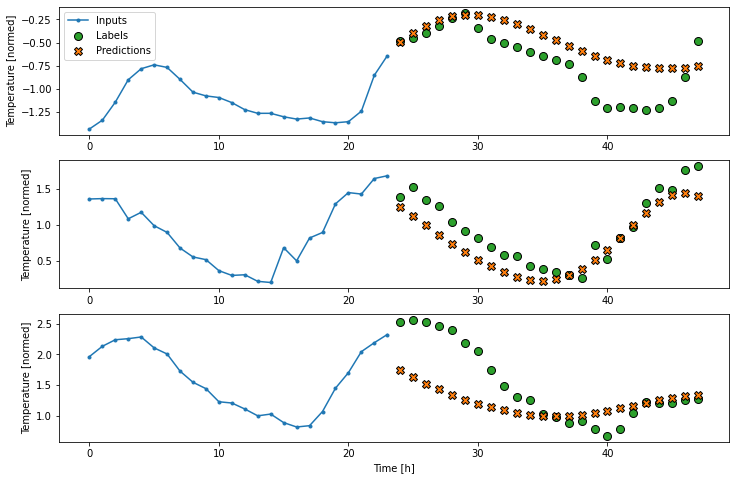

In [88]:
feedback_model = FeedBack(units = 64, out_steps = OUT_STEPS)

prediction, state = feedback_model.warmup(multi_window.example[0])



print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose = 0)
multi_window.plot(feedback_model)

43/43 [==============================] - 1s 12ms/step - loss: 0.5279 - mean_absolute_error: 0.3603


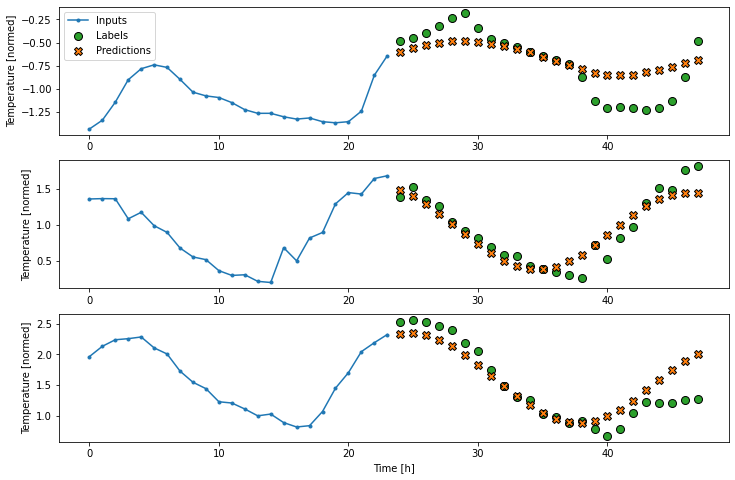

In [96]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.train, verbose=0)
multi_window.plot(multi_lstm_model)

In [98]:
city = 'Denver'

multi_lstm_model.save(f'../MODELS/{city}_model.h5')

In [130]:
from tensorflow import keras
model = keras.models.load_model('../MODELS/Jacksonville_model.h5')
print(model.summary())

predict_df = train_df.tail(24) #any dataframe 24 rows and 11 columns 
prediction_set = predict_df.to_numpy()[np.newaxis,:]

predictions = model.predict(prediction_set)

predictions = pd.DataFrame(predictions[0])

#replace columns with original columns
i = 0
for column in train_std.index:
    predictions.rename(columns = {i: column}, inplace = True)
    i+=1
    
predictions = (predictions * train_std) + train_mean

predictions.head()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5760      
_________________________________________________________________
dense_1 (Dense)              (None, 288)               9504      
_________________________________________________________________
reshape_1 (Reshape)          (None, 24, 12)            0         
Total params: 15,264
Trainable params: 15,264
Non-trainable params: 0
_________________________________________________________________
None


,Humidity,Pressure,Temperature,Wind_Speed,Year Temp Average,Month Temp Average,Year Pressure Average,Month Pressure Average,Year Wind_Speed Average,Month Wind_Speed Average,Year Humidity Average,Month Humidity Average
0,46.631996,1007.265869,283.754547,2.546173,283.049896,290.133118,1006.656067,1005.917542,2.760359,2.324667,49.777893,53.189949
1,51.426815,1005.219971,282.752899,2.240052,283.048187,290.125824,1006.648865,1005.906494,2.760918,2.323745,49.774483,53.212444
2,55.145157,1003.666260,282.195557,1.941761,283.046021,290.150452,1006.642212,1005.855103,2.762005,2.323186,49.764309,53.239517
3,58.273857,1003.243225,281.806915,1.604657,283.043152,290.158966,1006.634705,1005.844299,2.762703,2.321002,49.756886,53.262634
4,60.290981,1002.538879,281.836731,1.337085,283.039124,290.172882,1006.624878,1005.804077,2.763741,2.321082,49.744213,53.275658
